# Test Various CNN architectures on the layer identification task


In [1]:
import torch
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt


import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import confusion_matrix, accuracy_score

from models.utils import identify_device, test_classifier, display_model
from models.Classifier_models import CNN1D_Small, CNN1D_Large, train_model

## Import Data 

In [2]:
device = identify_device()

Using device: mps


In [3]:
# Load the dataset with weights_only=False
data = torch.load("mixed_data/mixed_noise_data_80k.pt", weights_only=False)

# Extract components
synthetic_data = data["synthetic_data"]
material_params = data["material_params"]
num_layers = data["num_layers"]

print("Dataset loaded successfully!")
print(f"Number of samples: {len(synthetic_data)}")
print(f"Shape of synthetic_data: {synthetic_data.shape}")
print(f"Shape of num_layers: {num_layers.shape}")
print(f"Example number of layers: {num_layers[:10]}")

num_classes = int(max(num_layers)) # class labels start at 1 not 0.

Dataset loaded successfully!
Number of samples: 80000
Shape of synthetic_data: torch.Size([80000, 1024])
Shape of num_layers: torch.Size([80000])
Example number of layers: tensor([2, 1, 1, 2, 1, 1, 2, 2, 3, 2])


In [4]:
# Adjust labels for training (CrossEntropyLoss expects 0-based class labels)
num_layers_adjusted = num_layers - 1  

# Ensure shapes are as expected
print("synthetic_data shape (after unsqueeze):", synthetic_data.unsqueeze(1).shape)
print("num_layers (original):", num_layers[:10])
print("num_layers_adjusted (for training):", num_layers_adjusted[:10])


synthetic_data shape (after unsqueeze): torch.Size([80000, 1, 1024])
num_layers (original): tensor([2, 1, 1, 2, 1, 1, 2, 2, 3, 2])
num_layers_adjusted (for training): tensor([1, 0, 0, 1, 0, 0, 1, 1, 2, 1])


In [5]:
# Dataset parameters
num_classes = int(num_layers_adjusted.max().item()) + 1  
batch_size = 256
val_ratio = 0.2  # 20% of the data for validation

# Add channel dimension for Conv1D input: [B, 1, 1024]
synthetic_data = synthetic_data.unsqueeze(1)  # [N, 1, 1024]

# Create TensorDataset
full_dataset = TensorDataset(synthetic_data, num_layers_adjusted)

# Split into train and validation sets
total_size = len(full_dataset)
val_size = int(val_ratio * total_size)
train_size = total_size - val_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## Train and Test Small CNN

In [6]:
display_model(CNN1D_Small(), device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 32, 1024]             192
         MaxPool1d-2              [-1, 32, 512]               0
            Conv1d-3              [-1, 64, 512]          10,304
         MaxPool1d-4              [-1, 64, 256]               0
            Conv1d-5             [-1, 128, 256]          41,088
            Linear-6                   [-1, 64]           8,256
           Dropout-7                   [-1, 64]               0
            Linear-8                    [-1, 3]             195
Total params: 60,035
Trainable params: 60,035
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.00
Params size (MB): 0.23
Estimated Total Size (MB): 1.23
----------------------------------------------------------------


In [7]:
# Initialize the model, criterion, and optimizer
model = CNN1D_Small(input_channels=1, num_classes=num_classes).to(device=device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)



print("Data shape:", synthetic_data.shape)
print("Label range:", num_layers_adjusted.min().item(), "to", num_layers_adjusted.max().item())
print("Number of classes:", num_classes)

Data shape: torch.Size([80000, 1, 1024])
Label range: 0 to 2
Number of classes: 3


In [8]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

print(f'\nTraining Hyper Parameters')
print(f'Batch Size: {batch_size}')
print(f'Learning Rate: {optimizer.param_groups[0]["lr"]}')

train_loss, train_acc, val_loss, val_acc, lr_vals = train_model(
    model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=200,
    verbose='epoch'
)


Training Hyper Parameters
Batch Size: 256
Learning Rate: 0.0001


Training epochs: 100%|██████████| 200/200 [18:43<00:00,  5.62s/epoch]


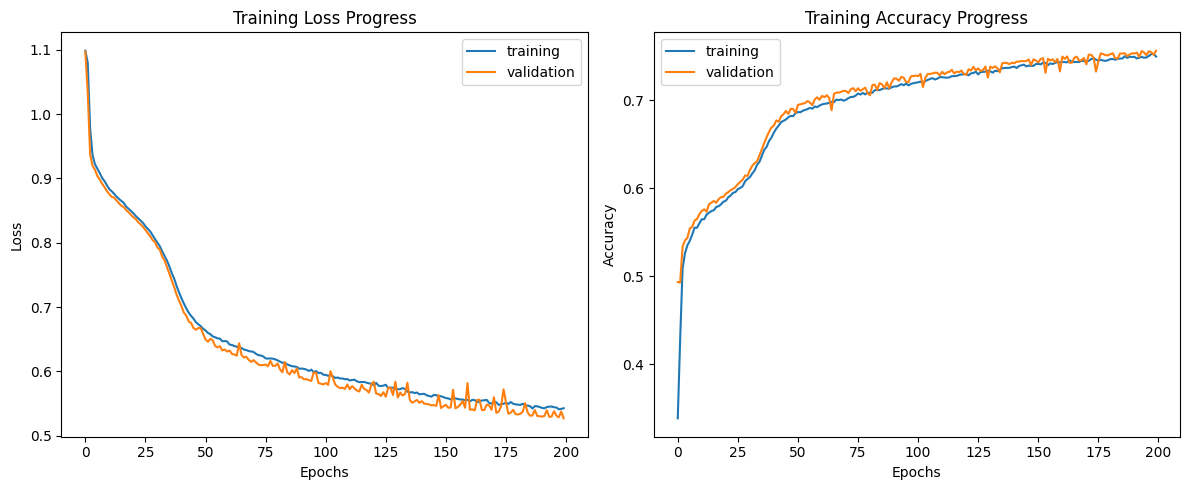

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))  

# Plot loss
axs[0].plot(train_loss, label='training')
axs[0].plot(val_loss, label='validation')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training Loss Progress')
axs[0].legend()

# Plot accuracy
axs[1].plot(train_acc, label='training')
axs[1].plot(val_acc, label='validation')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Training Accuracy Progress')
axs[1].legend()

plt.tight_layout()
plt.show()

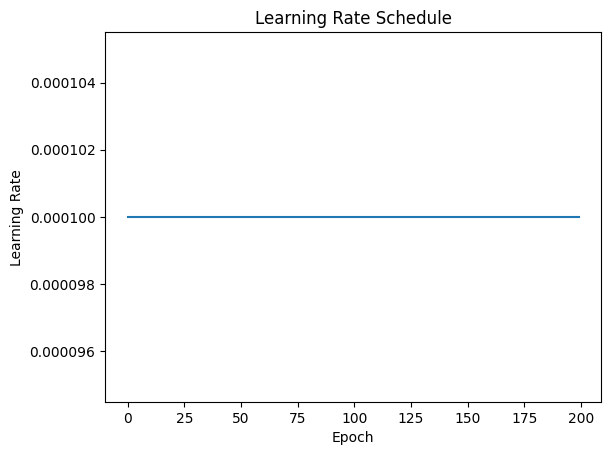

In [10]:
plt.plot(lr_vals)
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule")
plt.show()


Unseen dataset Accuracy: 0.7719

------------- Global Metrics -------------
Macro F1:           0.767
Weighted F1:        0.766
Macro Precision:    0.766
Weighted Precision: 0.765
Macro Recall:       0.773
Weighted Recall:    0.772

------------- Per-Class Metrics -------------
Layer        F1  Precision   Recall
Layer 1    0.904      0.863    0.949
Layer 2    0.633      0.698    0.580
Layer 3    0.763      0.738    0.790


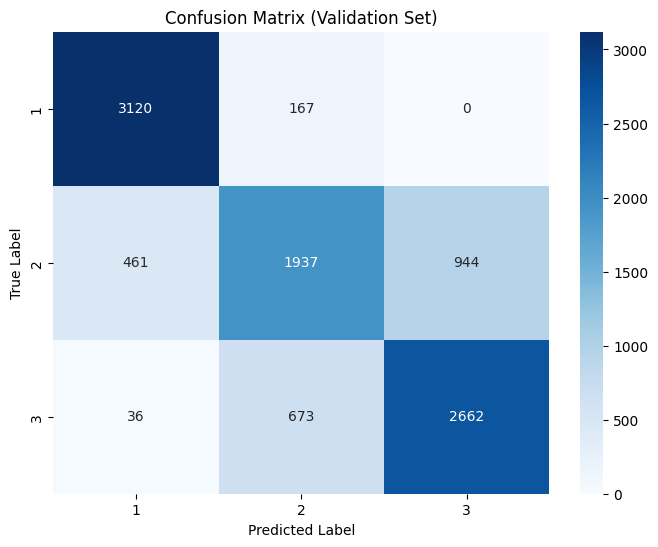

In [11]:
test_classifier(model, 'data/Validation.pt', device)

## Train and test Larger CNN

In [12]:
display_model(CNN1D_Large(), device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 64, 1024]             384
         GroupNorm-2             [-1, 64, 1024]             128
         MaxPool1d-3              [-1, 64, 512]               0
            Conv1d-4             [-1, 128, 512]          41,088
         GroupNorm-5             [-1, 128, 512]             256
         MaxPool1d-6             [-1, 128, 256]               0
            Conv1d-7             [-1, 256, 256]          98,560
         GroupNorm-8             [-1, 256, 256]             512
         MaxPool1d-9             [-1, 256, 128]               0
           Conv1d-10             [-1, 256, 128]         196,864
        GroupNorm-11             [-1, 256, 128]             512
        MaxPool1d-12              [-1, 256, 64]               0
AdaptiveAvgPool1d-13               [-1, 256, 1]               0
           Linear-14                   

In [13]:
batch_size = 128
val_ratio = 0.2  

# Split into train and validation sets
total_size = len(full_dataset)
val_size = int(val_ratio * total_size)
train_size = total_size - val_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [14]:
# Initialize the model, criterion, and optimizer
model = CNN1D_Large(input_channels=1, num_classes=num_classes).to(device=device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

print("Data shape:", synthetic_data.shape)
print("Label range:", num_layers_adjusted.min().item(), "to", num_layers_adjusted.max().item())
print("Number of classes:", num_classes)

Data shape: torch.Size([80000, 1, 1024])
Label range: 0 to 2
Number of classes: 3


In [15]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=7)

print(f'\nTraining Hyper Parameters')
print(f'Batch Size: {batch_size}')
print(f'Learning Rate: {optimizer.param_groups[0]["lr"]}')

train_loss, train_acc, val_loss, val_acc, lr_vals = train_model(
    model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=120,
    verbose='epoch'
)



Training Hyper Parameters
Batch Size: 128
Learning Rate: 0.0001


Training epochs: 100%|██████████| 120/120 [1:02:33<00:00, 31.28s/epoch]


In [23]:
# Optionally: save the model
torch.save(model.state_dict(), 'trained_models/large_CNN_hybrid_noise_trainset.pth')

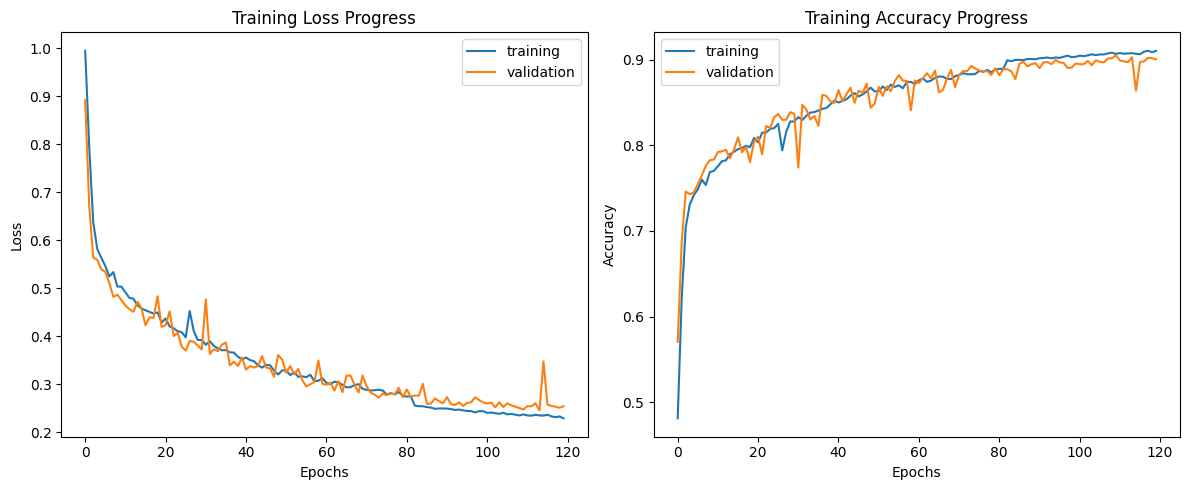

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))  

# Plot loss
axs[0].plot(train_loss, label='training')
axs[0].plot(val_loss, label='validation')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training Loss Progress')
axs[0].legend()

# Plot accuracy
axs[1].plot(train_acc, label='training')
axs[1].plot(val_acc, label='validation')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Training Accuracy Progress')
axs[1].legend()

plt.tight_layout()
plt.show()

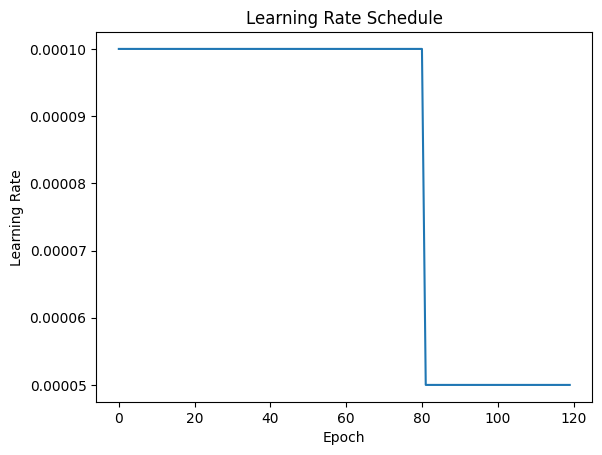

In [17]:
plt.plot(lr_vals)
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule")
plt.show()


Unseen dataset Accuracy: 0.9484

------------- Global Metrics -------------
Macro F1:           0.949
Weighted F1:        0.948
Macro Precision:    0.949
Weighted Precision: 0.949
Macro Recall:       0.949
Weighted Recall:    0.948

------------- Per-Class Metrics -------------
Layer        F1  Precision   Recall
Layer 1    0.991      0.983    1.000
Layer 2    0.924      0.905    0.944
Layer 3    0.930      0.959    0.902


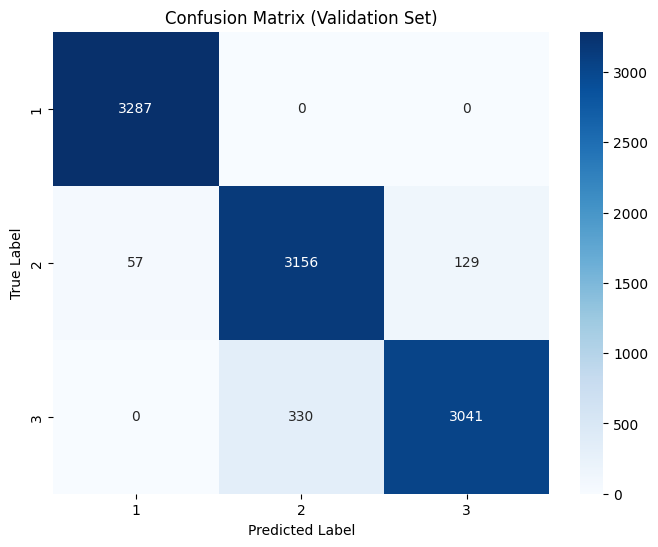

In [18]:
test_classifier(model, 'data/Validation.pt', device)


Unseen dataset Accuracy: 0.9489

------------- Global Metrics -------------
Macro F1:           0.949
Weighted F1:        0.949
Macro Precision:    0.949
Weighted Precision: 0.950
Macro Recall:       0.949
Weighted Recall:    0.949

------------- Per-Class Metrics -------------
Layer        F1  Precision   Recall
Layer 1    0.990      0.980    1.000
Layer 2    0.924      0.907    0.943
Layer 3    0.932      0.962    0.904


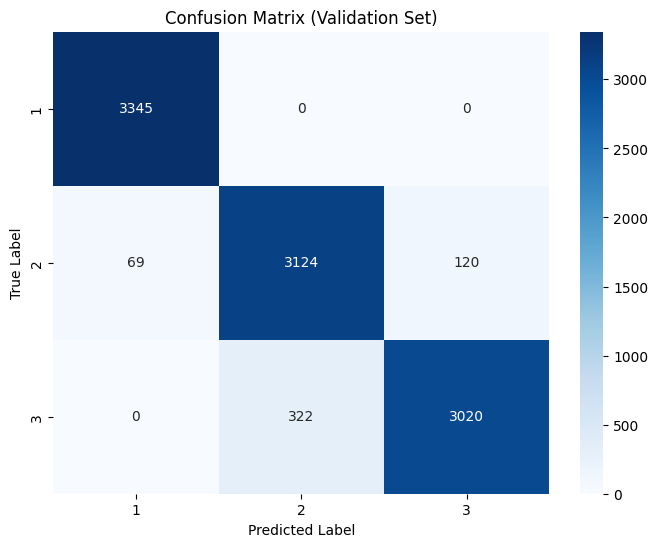

In [19]:
test_classifier(model, 'data/Validation_noise_1eneg3.pt', device)

## Test on noisy set


Unseen dataset Accuracy: 0.9472

------------- Global Metrics -------------
Macro F1:           0.947
Weighted F1:        0.947
Macro Precision:    0.947
Weighted Precision: 0.948
Macro Recall:       0.947
Weighted Recall:    0.947

------------- Per-Class Metrics -------------
Layer        F1  Precision   Recall
Layer 1    0.991      0.982    1.000
Layer 2    0.921      0.904    0.939
Layer 3    0.929      0.956    0.903


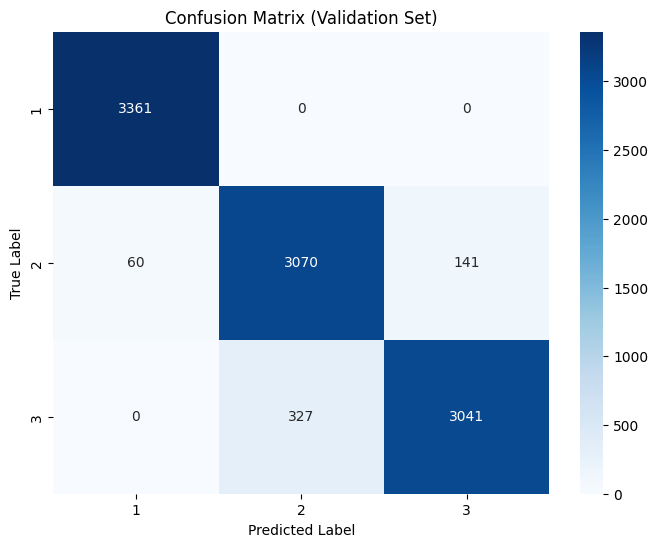

In [20]:
test_classifier(model, 'data/Validation_noise_1eneg4.pt', device)

In [21]:
#torch.save(model.state_dict(), 'trained_models/large_CNN_48k_clean_12k_val_120epochs_128batch.pth')